In [24]:
%load_ext autoreload
%autoreload 2

models/transfer_withgain_512:

Average FID: 75.52863769238729227272

Maximum FID: 115.51018689531007 (in subdirectory 16)

Minimum FID: 38.7466294030555 (in subdirectory 6)

## Sampling from DDIM

In [25]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 4
args.latent_dim = 128
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:0'

model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)

model.eval()

betas = prepare_noise_schedule(args.noise_steps, beta_start=args.beta_start, beta_end=args.beta_end)
sampler = SpacedDiffusion(beta_start=args.beta_start, beta_end=args.beta_end, noise_steps=args.noise_steps, section_counts=[20], img_height=64, img_width=128, device=device, rescale_timesteps=False)

E = 15
P = 15
ms = 20
n=4
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
x = sampler.ddim_sample_loop(model=model, y=y, cfg_scale=4, device=device, eta=1, n=n)



plot_image_pairs(x, xlim=[2,20], acquisition_time_ms=ms, electron_pointing_pixel=62)

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 256x64)

## Sampling from diffAE

In [ ]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 4
args.latent_dim = 128
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:0'

model = UNet_conditional(img_width=128, img_height=64, feat_num=args.latent_dim, device=device).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=args.noise_steps, section_counts=[20], img_height=64, img_width=128, device=device, rescale_timesteps=False)
model_sem = SemEncoder(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_sem_ckpt.pt", map_location=device)
model_sem.load_state_dict(ckpt)
model_lat = MLPSkipNet(device=device)
ckpt = torch.load("models/diffAE_new_cond/ema_lat_ckpt.pt", map_location=device)
model_lat.load_state_dict(ckpt)

model.eval()
model_sem.eval()
model_lat.eval()

betas_lat = prepare_noise_schedule(1000, beta_start=args.beta_start, beta_end=args.beta_end)
betas = prepare_noise_schedule(args.noise_steps, beta_start=args.beta_start, beta_end=args.beta_end)
lat_sampler = GaussianDiffusion(img_height=1, img_width=128, device=device, noise_steps=1000, betas=betas_lat)
sampler = SpacedDiffusion(beta_start=args.beta_start, beta_end=args.beta_end, noise_steps=args.noise_steps, section_counts=[20], img_height=64, img_width=128, device=device, rescale_timesteps=False)

E = 15
P = 15
ms = 20
n=4
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
sem = lat_sampler.sample_ddpm_lat(model=model_lat, n=n, settings=y, latent_dim=128)
x = sampler.ddim_sample_loop(model=model, y=sem, cfg_scale=4, device=device, eta=1, n=n)



plot_image_pairs(x, xlim=[2,20], acquisition_time_ms=ms, electron_pointing_pixel=62)

/home/jechmate/anaconda3/envs/eli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Error(s) in loading state_dict for SemEncoder:
	size mismatch for out.3.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for out.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).

## Stochastic encode

100%|██████████| 40/40 [00:01<00:00, 21.20it/s]


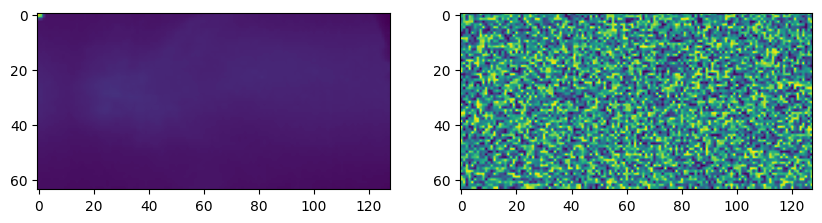

In [9]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 4
args.latent_dim = 256
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:2'

model = UNet_conditional(img_width=128, img_height=64, feat_num=args.latent_dim, device=device, time_dim=args.latent_dim).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=args.noise_steps, section_counts=[40], img_height=64, img_width=128, device=device, rescale_timesteps=False)
model_sem = SemEncoder(img_width=128, img_height=64, feat_num=3, device=device, latent_dim=args.latent_dim, time_dim=args.latent_dim).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_sem_ckpt.pt", map_location=device)
model_sem.load_state_dict(ckpt)

train_loader = get_data(args)
for data in train_loader:
    images = data['image'].to(device)
    sem = model_sem(images, data["settings"].to(device))
    x = sampler.encode_stochastic(model, images, sem, device)
    break

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
images = (images.clamp(-1, 1) + 1) / 2
images = (images * 255).type(torch.uint8)
x = (x + 1) / 2
x = (x * 255).type(torch.uint8)
ax[0].imshow(images[3].permute(1, 2, 0).cpu())
ax[1].imshow(x[3].permute(1, 2, 0).cpu())

## Reconstruction

100%|██████████| 40/40 [00:01<00:00, 26.96it/s]


tensor(-0.8501, device='cuda:2')
tensor(0.5877, device='cuda:2')
tensor([[[[132, 132, 132,  ..., 122, 122, 122],
          [132, 132, 132,  ..., 122, 122, 122],
          [132, 132, 132,  ..., 122, 122, 122],
          ...,
          [121, 121, 121,  ..., 121, 121, 121],
          [121, 121, 121,  ..., 121, 121, 121],
          [121, 121, 121,  ..., 121, 121, 121]]],


        [[[180, 180, 178,  ...,  78,  78,  78],
          [180, 180, 178,  ...,  78,  78,  78],
          [178, 178, 176,  ...,  79,  79,  79],
          ...,
          [ 80,  80,  79,  ...,  82,  82,  82],
          [ 80,  80,  80,  ...,  82,  83,  83],
          [ 80,  80,  80,  ...,  82,  83,  83]]],


        [[[166, 166, 162,  ..., 162, 171, 171],
          [166, 166, 162,  ..., 162, 171, 171],
          [163, 163, 159,  ..., 158, 166, 166],
          ...,
          [113, 113, 110,  ..., 145, 153, 153],
          [114, 114, 112,  ..., 155, 164, 164],
          [114, 114, 112,  ..., 155, 164, 164]]]], device='cuda:2'

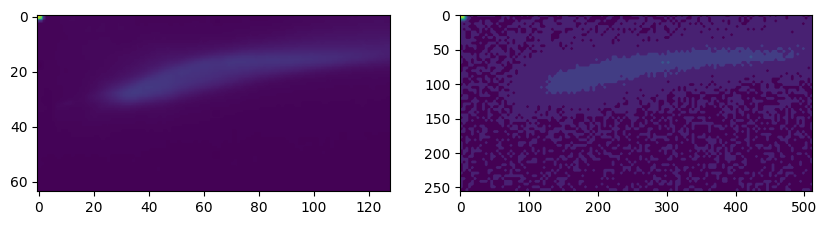

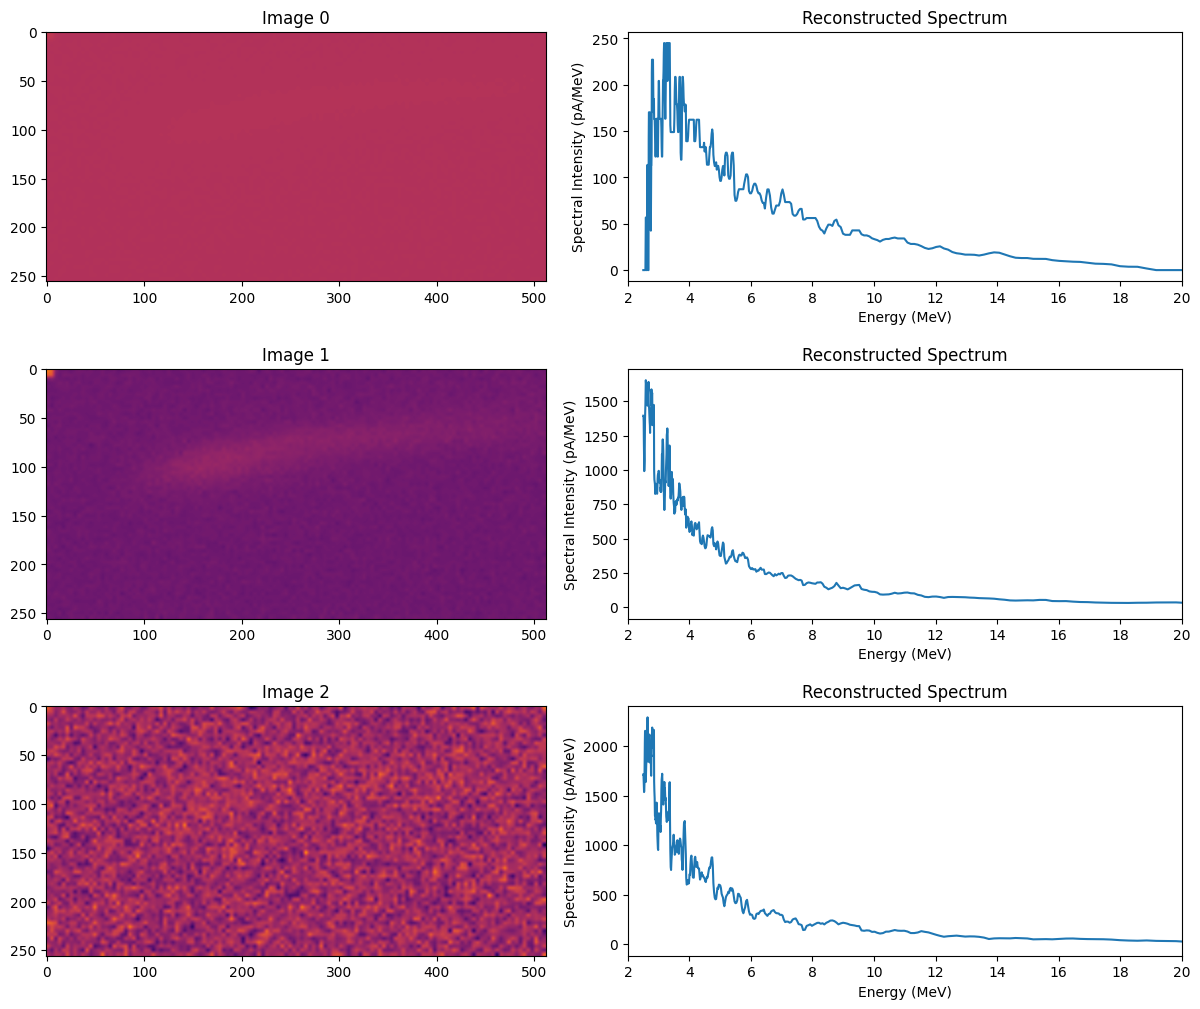

In [4]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 1
args.latent_dim = 256
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:2'

model = UNet_conditional(img_width=128, img_height=64, feat_num=args.latent_dim, device=device, time_dim=args.latent_dim).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=args.noise_steps, section_counts=[40], img_height=64, img_width=128, device=device, rescale_timesteps=False)
model_sem = SemEncoder(img_width=128, img_height=64, feat_num=3, device=device, latent_dim=args.latent_dim, time_dim=args.latent_dim).to(device)
ckpt = torch.load("models/diffAE_new_cond/ema_sem_ckpt.pt", map_location=device)
model_sem.load_state_dict(ckpt)

model.eval()
model_sem.eval()

train_loader = get_data(args)
for data in train_loader:
    images = data['image'].to(device)
    settings = data['settings'].to(device)
    sem = model_sem(images, settings).to(device)
    # x = sampler.sample_ddpm(model, 4, sem, resize=(128, 256))
    x = sampler.ddim_sample_loop(model, sem, device=device, n=3)
    break

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
images = (images.clamp(-1, 1) + 1) / 2
images = (images * 255).type(torch.uint8)
print(x)
# x = (x.clamp(-1, 1) + 1) / 2
# x = (x * 255).type(torch.uint8)
ax[0].imshow(images[0].permute(1, 2, 0).cpu())
ax[1].imshow(x[0].permute(1, 2, 0).cpu())

plot_image_pairs(x, xlim=[2,20], acquisition_time_ms=20, electron_pointing_pixel=62)

0.011764705882352941
0.47843137254901963
0.30980392156862746
0.4235294117647059


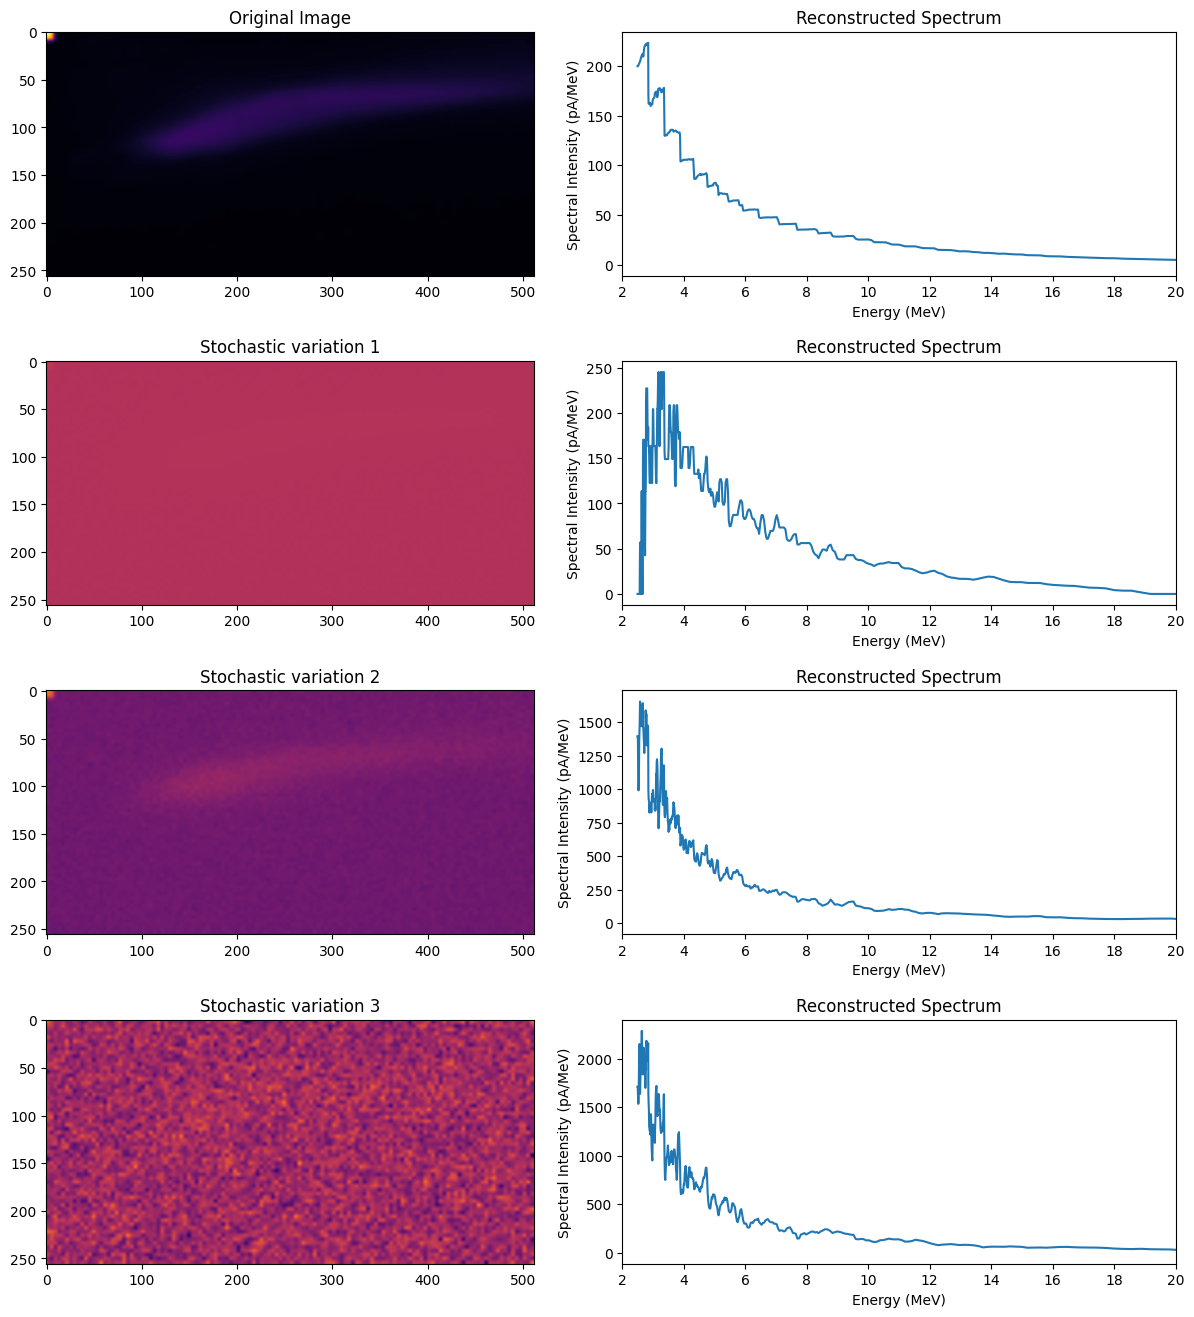

In [5]:
import torch
import torchvision.transforms.functional as f

images = f.resize(images, (256,512), antialias=True)
plot_image_pairs(torch.cat([images, x]), xlim=[2,20], acquisition_time_ms=20, electron_pointing_pixel=62, titles=['Original Image', 'Stochastic variation 1', 'Stochastic variation 2', 'Stochastic variation 3'])